# Baseline Test #
Our first baseline is to simply use the Glicko-2 player rank to predict the outcome of the set.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict
import matplotlib.pyplot as plt
# from numba import njit, prange

import sqlite3
import sys
import time
import tqdm

In [3]:
glicko2_df = pd.read_pickle('../data/overall_players_ranking.pkl')
glicko2_df.head(2)

,dates,rating_history,rd_history,glicko2
player_id,,,,
1000,"[2015-01-13 01:02:28, 2015-02-06 18:58:36, 201...","[1669.3438572516538, 1699.3674585229132, 1882....","[171.20863576993426, 129.71212804199854, 83.73...",<glicko2.glicko2.Player object at 0x7ff20fb18320>
Stelzig,"[2015-01-13 01:02:28, 2015-08-17 23:13:14]","[1252.6819167554638, 1165.5738869144382]","[253.40460822505193, 211.92970378109877]",<glicko2.glicko2.Player object at 0x7ff20fb2d910>


In [4]:
# Function to get the table names
def get_table_names(conn):
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    return pd.read_sql(query, conn)['name'].tolist()

# Function to load tables into DataFrames
def load_tables_to_dfs(conn):
    table_names = get_table_names(conn)
    dataframes = {}
    
    for table in table_names:
        # Load table into a DataFrame
        df = pd.read_sql(f"SELECT * FROM {table}", conn)
        
        # Detect and convert JSON formatted columns (if any)
        for col in df.columns:
            # Check if any entry in the column is a valid JSON (list or dictionary)
            if df[col].apply(lambda x: isinstance(x, str)).all():
                try:
                    # Try parsing the column as JSON
                    df[col] = df[col].apply(lambda x: json.loads(x) if pd.notnull(x) else x)
                except (json.JSONDecodeError, TypeError):
                    # If it fails, skip the column
                    pass
        
        # Store the DataFrame with table name + '_df'
        dataframes[f"{table}_df"] = df
        
    return dataframes

# Check if the flag variable exists in the global scope so that this code does not run twice
if 'cell_has_run' not in globals():
    path = "../data/melee_player_database.db"
    
    # Connect to the database
    conn = sqlite3.connect(path)

    # Convert each table into a DataFrame
    dfs = load_tables_to_dfs(conn)

    # Close the connection
    conn.close()

    # Now, you have a dictionary 'dfs' where each key is the table name with '_df' suffix and value is the corresponding DataFrame.
    # For example, to access the DataFrame for a table called 'players':
    # players_df = dfs['players_df']

    dfs['tournament_info_df']['start'] = pd.to_datetime(dfs['tournament_info_df']['start'], unit='s')
    dfs['tournament_info_df']['end'] = pd.to_datetime(dfs['tournament_info_df']['end'], unit='s')

    
    # Set the flag to indicate that the cell has been run
    cell_has_run = True

In [5]:
players_df = dfs['players_df']
ranking_df = dfs['ranking_df']
ranking_seasons_df = dfs['ranking_seasons_df']
sets_df = dfs['sets_df']
tournament_info_df = dfs['tournament_info_df']

print(players_df.head(1))
print(ranking_df.head(1))
print(ranking_seasons_df.head(1))
print(sets_df.head(1))
print(tournament_info_df.head(1))

    game player_id    tag all_tags prefixes           social country state  \
0  melee     Rishi  Rishi  [Rishi]       []  {'twitter': []}                 

  region c_country c_state c_region  \
0             None    None     None   

                                            placings characters alias  
0  [{'key': 'mdva-invitational-2017-(challonge-mi...             None  
    game ranking_name  priority region                         seasons  \
0  melee     SSBMRank         0  world  [2015, 2016, 2017, 2018, 2019]   

  tournaments  icon  
0          []  miom  
    game ranking_name  season       start         end  total  \
0  melee     SSBMRank    2015  1420070400  1451606399    100   

                                               by_id  \
0  {'6189': 1, '1004': 2, '4465': 3, '1000': 4, '...   

                                          by_placing  final  name  
0  {'1': '6189', '2': '1004', '3': '4465', '4': '...      0  None  
         key   game                             t

In [6]:
def check_set(glicko2_df, set, tournament_info_df, correct_predictions):
    tournament = set['tournament_key']
    p1_id = set['p1_id']
    p2_id = set['p2_id']
    start_date = tournament_info_df[tournament_info_df['key']==tournament]['start']
    
    p1_index = np.searchsorted(glicko2_df.loc[p1_id,'dates'], start_date) - 1
    p2_index = np.searchsorted(glicko2_df.loc[p2_id,'dates'], start_date) - 1
    
    p1_glikco2 = glicko2_df.loc[p1_id,'rating_history'][p1_index]
    p2_glikco2 = glicko2_df.loc[p2_id,'rating_history'][p2_index]
    
    if p1_glikco2 > p2_glikco2 and set['winner_id'] == p1_id:
        return  1
    if p1_glikco2 < p2_glikco2 and set['winner_id'] == p2_id:
        return 1
    
    return 0
        
num_sets = 6000
random_set_sample = sets_df.sample(n = num_sets, random_state=42)   
correct_predictions = 0

for j in tqdm.tqdm(range(num_sets)):
    correct_predictions += check_set(glicko2_df, random_set_sample.iloc[j], tournament_info_df, correct_predictions)

print(f'The higher Glicko-2 rating wins {correct_predictions/num_sets:0.1%} of the time')

100%|██████████| 6000/6000 [00:08<00:00, 719.81it/s]

The higher Glicko-2 rating wins 78.4% of the time


I need to check the following optimized version from ChatGPT because it does not match the result of the one that I wrote.

In [7]:

# Assuming 'sets_df', 'glicko2_df', and 'tournament_info_df' are already defined

# num_sets = 600# sets_df.shape[0]
random_set_sample = sets_df#.sample(n=num_sets, random_state=42)

# Merge with 'tournament_info_df' to get 'start' date
random_set_sample = random_set_sample.merge(
    tournament_info_df[['key', 'start']],
    left_on='tournament_key',
    right_on='key',
    how='left'
)

# Ensure date columns are datetime
random_set_sample['start'] = pd.to_datetime(random_set_sample['start'])

# Flatten 'glicko2_df'
glicko2_long = glicko2_df[['dates', 'rating_history']].reset_index()
glicko2_long = glicko2_long.explode(['dates', 'rating_history'])
glicko2_long.rename(columns={'dates': 'date', 'rating_history': 'rating'}, inplace=True)
glicko2_long['date'] = pd.to_datetime(glicko2_long['date'])

# For Player 1
p1_data = random_set_sample[['p1_id', 'start']].rename(columns={'p1_id': 'player_id'})
p1_data['key'] = p1_data.index

p1_ratings = pd.merge_asof(
    p1_data.sort_values('start'),
    glicko2_long.sort_values('date'),
    by='player_id',
    left_on='start',
    right_on='date',
    direction='backward'
).set_index('key')

# For Player 2
p2_data = random_set_sample[['p2_id', 'start']].rename(columns={'p2_id': 'player_id'})
p2_data['key'] = p2_data.index

p2_ratings = pd.merge_asof(
    p2_data.sort_values('start'),
    glicko2_long.sort_values('date'),
    by='player_id',
    left_on='start',
    right_on='date',
    direction='backward'
).set_index('key')

# Combine ratings
combined_ratings = pd.DataFrame({
    'p1_rating': p1_ratings['rating'],
    'p2_rating': p2_ratings['rating'],
    'winner_id': random_set_sample['winner_id'],
    'p1_id': random_set_sample['p1_id'],
    'p2_id': random_set_sample['p2_id']
})

# Drop missing ratings
combined_ratings.dropna(subset=['p1_rating', 'p2_rating'], inplace=True)

# Update number of sets
num_sets = combined_ratings.shape[0]

# Determine if the higher-rated player won
higher_p1_wins = (
    (combined_ratings['p1_rating'] > combined_ratings['p2_rating']) &
    (combined_ratings['winner_id'] == combined_ratings['p1_id'])
)
higher_p2_wins = (
    (combined_ratings['p2_rating'] > combined_ratings['p1_rating']) &
    (combined_ratings['winner_id'] == combined_ratings['p2_id'])
)
correct_predictions = (higher_p1_wins | higher_p2_wins).sum()

print(f'The higher Glicko-2 rating wins {correct_predictions / num_sets:0.1%} of the time')
print(f'There were {correct_predictions} correct predictions out of {num_sets} sets.')


The higher Glicko-2 rating wins 77.8% of the time
There were 1158270 correct predictions out of 1489592 sets.


/tmp/ipykernel_139188/3864550134.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = combined_ratings.groupby('rating_diff_bin')['higher_rated_won'].agg(['mean', 'count'])


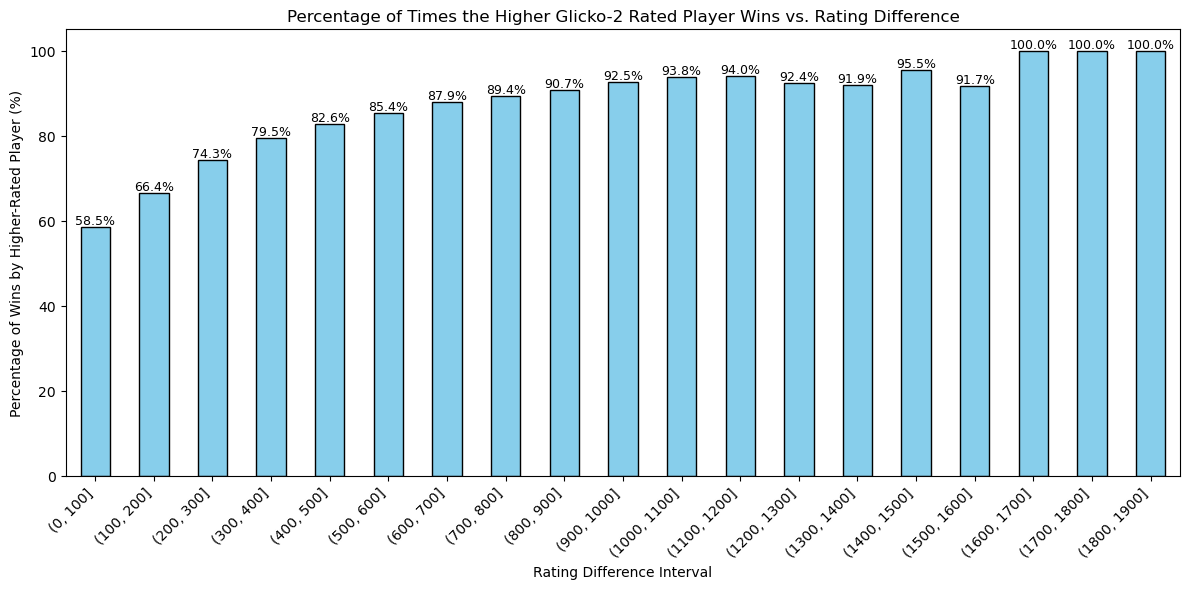

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'combined_ratings' DataFrame is already defined
# and contains 'p1_rating', 'p2_rating', 'p1_id', 'p2_id', and 'winner_id'

# Compute rating difference
combined_ratings['rating_diff'] = abs(combined_ratings['p1_rating'] - combined_ratings['p2_rating'])

# Determine if the higher-rated player won
combined_ratings['higher_rated_won'] = (
    ((combined_ratings['rating_diff'] > 0) & (combined_ratings['winner_id'] == combined_ratings['p1_id'])) |
    ((combined_ratings['rating_diff'] < 0) & (combined_ratings['winner_id'] == combined_ratings['p2_id']))
)

# Bin the rating differences with bin sizes of 100
bin_size = 100
min_rating_diff = combined_ratings['rating_diff'].min()
max_rating_diff = combined_ratings['rating_diff'].max()
bins = np.arange(
    np.floor(min_rating_diff / bin_size) * bin_size,
    np.ceil(max_rating_diff / bin_size) * bin_size + bin_size,
    bin_size, dtype=int
)

# Assign bins without specifying labels (default labels are intervals)
combined_ratings['rating_diff_bin'] = pd.cut(combined_ratings['rating_diff'], bins)

# Group by bins and compute the percentage of higher-rated player wins
result = combined_ratings.groupby('rating_diff_bin')['higher_rated_won'].agg(['mean', 'count'])
result['mean'] = result['mean'] * 100  # Convert to percentage

# Reset index to turn 'rating_diff_bin' into a column
result = result.reset_index()

# Convert interval labels to strings for x-axis labels
result['rating_diff_bin_str'] = result['rating_diff_bin'].astype(str)

# Plot the histogram
plt.figure(figsize=(12, 6))
ax = result['mean'].plot(kind='bar', color='skyblue', edgecolor='black')

# Set x-axis labels to be the interval strings
ax.set_xticklabels(result['rating_diff_bin_str'])

plt.title('Percentage of Times the Higher Glicko-2 Rated Player Wins vs. Rating Difference')
plt.xlabel('Rating Difference Interval')
plt.ylabel('Percentage of Wins by Higher-Rated Player (%)')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of each bar
for p, value in zip(ax.patches, result['mean']):
    height = p.get_height()
    ax.annotate(f'{value:.1f}%', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
